# 04 — SVM + Embeddings

Classificador **SVC (RBF kernel)** com features de embeddings pré-treinados.

**Estratégia de embeddings:**
1. NILC FastText 300d (se disponível em `data/embeddings/`)
2. Fallback: spaCy `pt_core_news_sm` (96d)

**Configuração:**
- Mean pooling: média dos vetores de palavras do documento
- SVC(kernel='rbf', class_weight='balanced')
- GridSearchCV com subsample (10K) + treino final em dados completos

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import joblib

from src.config import (
    SVM_RBF_C_VALUES, SVM_GAMMA_VALUES, MODELS_DIR, SEED, EMBEDDINGS_DIR,
)
from src.data_loader import carregar_splits
from src.feature_extraction import carregar_embeddings, textos_para_embeddings
from src.evaluation import calcular_metricas, salvar_metricas, plotar_matriz_confusao
from src.utils import set_seed, timer

set_seed()

## 1. Carregar Dados

In [2]:
df_train, df_val, df_test = carregar_splits()

textos_treino = df_train["texto_emb"].fillna("").tolist()
textos_val = df_val["texto_emb"].fillna("").tolist()
textos_teste = df_test["texto_emb"].fillna("").tolist()

y_train = df_train["label"].values
y_val = df_val["label"].values
y_test = df_test["label"].values

print(f"Treino: {len(textos_treino):,} | Val: {len(textos_val):,} | Teste: {len(textos_teste):,}")

Splits carregados: treino=90,368 | val=19,365 | teste=19,365
Treino: 90,368 | Val: 19,365 | Teste: 19,365


## 2. Gerar Embeddings

Tenta FastText; se não disponível, usa spaCy `pipe()` para processamento eficiente em batch.

In [3]:
USE_FASTTEXT = False

try:
    wv = carregar_embeddings()
    USE_FASTTEXT = True
    print("Usando FastText pré-treinado")
except FileNotFoundError as e:
    print(f"FastText não disponível: {e}")
    print("Usando spaCy pt_core_news_sm como fallback")

FastText não disponível: Nenhum arquivo de embeddings encontrado em /Users/devsquad/PLN-sentiments/data/embeddings. Baixe NILC FastText (cbow_s300.txt) ou Facebook cc.pt.300.bin e coloque em data/embeddings/
Usando spaCy pt_core_news_sm como fallback


In [4]:
EMBED_DIM = 96  # pt_core_news_sm dimensão

def extrair_embeddings_batch(textos, desc="Embeddings"):
    """Extrai embeddings usando spaCy pipe (batch) para eficiência."""
    nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner"])
    vetores = []
    for doc in tqdm(nlp.pipe(textos, batch_size=512, n_process=1), total=len(textos), desc=desc):
        vec = doc.vector
        if vec.shape == (0,) or vec.shape != (EMBED_DIM,):
            vetores.append(np.zeros(EMBED_DIM))
        else:
            vetores.append(vec)
    result = np.array(vetores, dtype=np.float32)
    n_zeros = np.sum(np.all(result == 0, axis=1))
    if n_zeros > 0:
        print(f"  {n_zeros} textos sem embedding (vetor zero)")
    print(f"{desc}: shape={result.shape}")
    return result

if USE_FASTTEXT:
    with timer("Embeddings treino"):
        X_train = textos_para_embeddings(textos_treino, wv)
    with timer("Embeddings val"):
        X_val = textos_para_embeddings(textos_val, wv)
    with timer("Embeddings teste"):
        X_test = textos_para_embeddings(textos_teste, wv)
else:
    with timer("Embeddings treino (spaCy batch)"):
        X_train = extrair_embeddings_batch(textos_treino, "Treino")
    with timer("Embeddings val (spaCy batch)"):
        X_val = extrair_embeddings_batch(textos_val, "Val")
    with timer("Embeddings teste (spaCy batch)"):
        X_test = extrair_embeddings_batch(textos_teste, "Teste")

print(f"\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

Treino:   0%|          | 0/90368 [00:00<?, ?it/s]

  72 textos sem embedding (vetor zero)
Treino: shape=(90368, 96)
⏱ Embeddings treino (spaCy batch): 3min 42.3s


Val:   0%|          | 0/19365 [00:00<?, ?it/s]

  14 textos sem embedding (vetor zero)
Val: shape=(19365, 96)
⏱ Embeddings val (spaCy batch): 45.6s


Teste:   0%|          | 0/19365 [00:00<?, ?it/s]

  13 textos sem embedding (vetor zero)
Teste: shape=(19365, 96)
⏱ Embeddings teste (spaCy batch): 37.3s

X_train: (90368, 96), X_val: (19365, 96), X_test: (19365, 96)


## 3. Normalização

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 4. GridSearchCV com Subsample

SVC RBF é O(n²) — usamos subsample estratificado de 10K para busca de hiperparâmetros.

In [6]:
# Subsample estratificado para GridSearch (SVC RBF é lento em dados grandes)
GRID_SAMPLE_SIZE = 10_000

if len(X_train_scaled) > GRID_SAMPLE_SIZE:
    X_grid, _, y_grid, _ = train_test_split(
        X_train_scaled, y_train,
        train_size=GRID_SAMPLE_SIZE,
        random_state=SEED,
        stratify=y_train,
    )
    print(f"Subsample para GridSearch: {len(X_grid):,} amostras")
else:
    X_grid, y_grid = X_train_scaled, y_train

param_grid = {
    "C": SVM_RBF_C_VALUES,
    "gamma": SVM_GAMMA_VALUES,
}

svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    random_state=SEED,
)

with timer("GridSearchCV SVM+Embeddings"):
    grid = GridSearchCV(
        svm,
        param_grid,
        cv=3,
        scoring="f1_weighted",
        verbose=1,
        n_jobs=-1,
    )
    grid.fit(X_grid, y_grid)

print(f"\nMelhores params: {grid.best_params_}")
print(f"Melhor F1 (CV): {grid.best_score_:.4f}")

Subsample para GridSearch: 10,000 amostras
Fitting 3 folds for each of 8 candidates, totalling 24 fits


⏱ GridSearchCV SVM+Embeddings: 1min 24.7s

Melhores params: {'C': 10, 'gamma': 'auto'}
Melhor F1 (CV): 0.6705


## 5. Treinar Modelo Final com Melhores Hiperparâmetros

In [7]:
best_params = grid.best_params_

with timer("Treino final SVM+Embeddings"):
    best_svm = SVC(
        kernel="rbf",
        class_weight="balanced",
        random_state=SEED,
        **best_params,
    )
    best_svm.fit(X_train_scaled, y_train)

print("Modelo treinado com dados completos!")

⏱ Treino final SVM+Embeddings: 108min 42.2s
Modelo treinado com dados completos!


## 6. Avaliação

In [8]:
y_val_pred = best_svm.predict(X_val_scaled)
metricas_val = calcular_metricas(y_val, y_val_pred, "SVM+Emb (Val)")


Resultados: SVM+Emb (Val)
Accuracy:  0.6902
F1 (weighted): 0.6948
Precision: 0.7047
Recall:    0.6902

Classification Report:
              precision    recall  f1-score   support

    negativo       0.63      0.75      0.68      5066
      neutro       0.25      0.26      0.25      2401
    positivo       0.83      0.75      0.79     11898

    accuracy                           0.69     19365
   macro avg       0.57      0.59      0.57     19365
weighted avg       0.70      0.69      0.69     19365



In [9]:
y_test_pred = best_svm.predict(X_test_scaled)

emb_tipo = "FastText" if USE_FASTTEXT else "spaCy"
metricas_teste = calcular_metricas(y_test, y_test_pred, f"SVM+Embeddings")
salvar_metricas(metricas_teste, "metricas_svm+embeddings.json")


Resultados: SVM+Embeddings
Accuracy:  0.6892
F1 (weighted): 0.6919
Precision: 0.6993
Recall:    0.6892

Classification Report:
              precision    recall  f1-score   support

    negativo       0.62      0.74      0.68      5066
      neutro       0.24      0.24      0.24      2402
    positivo       0.83      0.76      0.79     11897

    accuracy                           0.69     19365
   macro avg       0.56      0.58      0.57     19365
weighted avg       0.70      0.69      0.69     19365

Métricas salvas em /Users/devsquad/PLN-sentiments/models/metricas_svm+embeddings.json


PosixPath('/Users/devsquad/PLN-sentiments/models/metricas_svm+embeddings.json')

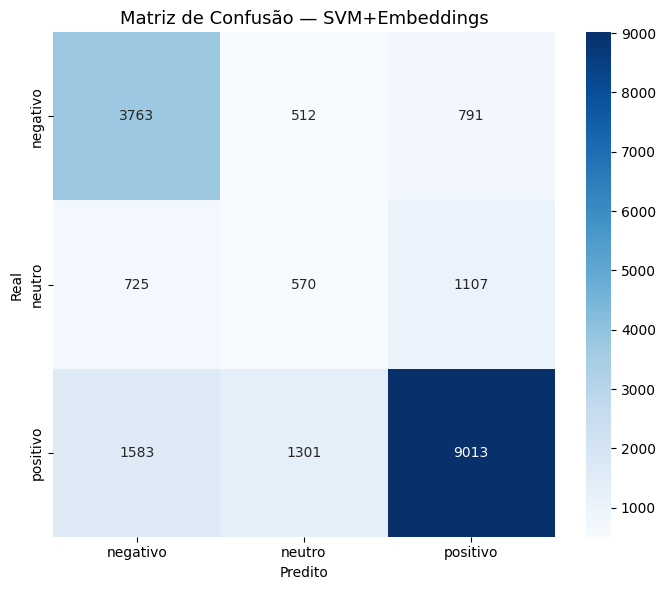

In [10]:
fig = plotar_matriz_confusao(y_test, y_test_pred, f"SVM+Embeddings")
plt.show()

## 7. Salvar Modelo

In [11]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(best_svm, MODELS_DIR / "svm_embeddings.joblib")
joblib.dump(scaler, MODELS_DIR / "scaler_embeddings.joblib")
print(f"Modelo SVM+Embeddings ({emb_tipo}) salvo!")

Modelo SVM+Embeddings (spaCy) salvo!


## Resumo

- SVC (RBF) treinado com embeddings (mean pooling)
- GridSearchCV em subsample (10K) para eficiência, retreino em dados completos
- Métricas salvas para comparação final
- Próximo passo: **05_bert.ipynb**